# Projet de création d'un algorithme de détection de faux billets

## ONCFM

In [1418]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
import pingouin as pg
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Importation des données

In [1419]:
data = pd.read_csv("../Documents/Sana/Data Analyst/P10/billets.csv", sep=';')
data.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16


In [1420]:
billets = pd.read_csv("../Documents/Sana/Data Analyst/P10/billets_production.csv")
billets

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


### Vérification des données

In [1421]:
data.shape

(1500, 7)

In [1422]:
data.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [1423]:
data.isna().mean()

is_genuine      0.000000
diagonal        0.000000
height_left     0.000000
height_right    0.000000
margin_low      0.024667
margin_up       0.000000
length          0.000000
dtype: float64

On voit que 2,5% des valeurs de la colonne margin_low sont manquantes. Pour remédier à ce problème, on réalise une régression linéaire :

### Remplissage des valeurs manquantes par régression linéaire

On commence par ne garder que la partie des données où la margin low n'est pas manquante afin d'y effectuer l'entraînement de l'algorithme et le test d'évaluation.

On normalise également les données afin de pouvoir y appliquer la régression linéaire.

In [1424]:
feature_cols = data.columns.drop('is_genuine')

scaler = preprocessing.StandardScaler()

tmp = pd.DataFrame(scaler.fit_transform(data.drop(columns = {'is_genuine'})), columns = feature_cols)
tmp['is_genuine'] = data['is_genuine']
data = tmp
data.head(3)

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine
0,-0.486540,2.774123,3.163240,0.051286,-1.128325,0.173651,True
1,-1.633729,-2.236535,-0.799668,-1.078937,-0.696799,0.471666,True
2,2.397823,1.504756,-1.291191,-0.129549,-0.912562,0.551901,True


In [1425]:
data_not_null = data[~data['margin_low'].isna()]

In [1426]:
X = data_not_null[feature_cols.drop('margin_low')]
y = data_not_null['margin_low']

On sépare le dataset en données d'entraînement et de test d'évaluation.

In [1427]:
X_train, X_test, y_train, y_pred = train_test_split(X,y)

On entraîne le modèle de régression linéaire sur les données.

In [1428]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [1429]:
print("r² = ", linreg.score(X_train, y_train))

r² =  0.4837305429892017


On obtient un score de r² qui avoisinne 0.4, ce qui rend compte d'une faible qualité du modèle.

On affiche les coefficients de chaque variable pour voir laquelle à la plus grande contribution à la valeur de la margin_low :

In [1430]:
print(linreg.intercept_)
for i in zip(feature_cols.drop('margin_low'), linreg.coef_) :
    print(i)

0.017103138216448998
('diagonal', -0.028416762365018826)
('height_left', 0.0890865456469832)
('height_right', 0.11175974324411936)
('margin_up', 0.07623095822325804)
('length', -0.5652198809665675)


On observe que la longueur est la variable qui est la plus corrélée avec la margin_low, la moins corrélée étant la diagonale.

On teste le modèle sur l'autre partie des données :

In [1431]:
y_pred = linreg.predict(X_test)

In [1432]:
y_test = data_not_null.loc[X_test.index]['margin_low'].values

In [1433]:
print("Score de justesse : ", round(100*linreg.score(X_test, y_test),1), "%")

Score de justesse :  45.4 %


On obtient un score de justesse de d'environ 50%, ce qui, comme on pouvait s'y attendre, est assez médiocre.

On insère les valeurs nouvellement imputées dans une copie du dataframe :

In [1434]:
data_null = data[data['margin_low'].isna()]
X_pred = data_null[feature_cols.drop('margin_low')]
y_pred = data_null['margin_low']

In [1435]:
y_pred = pd.Series(linreg.predict(X_pred), index = X_pred.index)
data_null['margin_low'] = y_pred
data_linreg = pd.concat([data_not_null, data_null])

C:\Users\SANAT_~1\AppData\Local\Temp/ipykernel_13872/2465630089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_null['margin_low'] = y_pred


Pour tenter d'expliquer les résultats médiocres de la régression linéaire, on peut vérifier si les conditions de celle-ci sont bien respectées. Nous allons vérifier la normalité des variables, leur homoscédasticité et leur multicolinéarité :

In [1436]:
pg.normality(data_linreg)

,W,pval,normal
diagonal,0.998686,3.239822e-01,True
height_left,0.997901,5.088592e-02,True
height_right,0.999518,9.806846e-01,True
margin_low,0.937572,1.306002e-24,False
margin_up,0.996166,8.113563e-04,False
length,0.917601,7.863536e-28,False
is_genuine,0.594887,0.000000e+00,False


In [1437]:
pg.homoscedasticity(data_linreg)

,W,pval,equal_var
levene,121.058591,1.811369e-148,False


In [1438]:
vif = pd.DataFrame()
vif['features'] = feature_cols
vif['VIF'] = [variance_inflation_factor(data_linreg[feature_cols].values, i) for i in range(len(feature_cols))]
vif

,features,VIF
0,diagonal,1.017785
1,height_left,1.158861
2,height_right,1.260119
3,margin_low,1.937361
4,margin_up,1.419064
5,length,2.144113


En effet, on observe que les variables ne sont pas toutes distribuées normalement, ce qui est une condition pour une bonne régression linéaire, on voit aussi que les variables ne sont pas homoscédastiques. En revanche, elles ne sont pas colinéaires entre elles.

De fait, la qualité de la régression n'est pas étonnante.

### Autre méthode d'imputation des valeurs manquanes : l'algorithme k-NN

On tente une autre méthode pour imputer les valeurs manquantes de notre dataset : l'algorithme des k-NN.

Cette fois-ci, on va procéder de la manière suivante :

Comme l'algorithme des k-NN n'a pas besoin d'entraînement sur des données séparées, mais qu'au contraire, il agit de manière unique sur l'ensemble des données, on va l'essayer sur le dataframe standardisé où il n'y a pas de valeurs manquantes, afin d'en évaluer la qualité.

On va simuler un entraînement/évaluation du modèle en prenant une copie des données de valeurs connues, et en en supprimant certaines valeurs (aléatoires). Ensuite, on voit avec quel justesse le modèle a réimputé ces valeurs.

Pour cela, on crée une liste d'indexes aléatoires de longueur avoisinnant les 20% du dataset. Ensuite, on crée une boucle sur les données d'entraînement afin d'en supprimer certaines valeurs, d'index généré aléatoirement.

In [1439]:
length = len(data_not_null)
random_index = random.sample(range(0, length+1), int(length/5))
data_not_null_nan = data_not_null.copy()

In [1440]:
for i in random_index :
    if i in data_not_null.index :
        data_not_null_nan.loc[i, 'margin_low'] = np.nan

print("On a généré ", data_not_null_nan['margin_low'].isna().sum(), "valeurs manquantes.")

On a généré  286 valeurs manquantes.


In [1441]:
knn = KNNImputer()
knn.fit(data_not_null_nan)

KNNImputer()

In [1442]:
data_not_null_nan = pd.DataFrame(knn.transform(data_not_null_nan), 
                                 columns = data_not_null.columns, index = data_not_null.index)

In [1443]:
print("Pourcentage de ressemblance entre les deux datasets : ", 
      round(100*(data_not_null['margin_low'] == data_not_null_nan['margin_low']).astype(int).sum()/length, 1), "%")

Pourcentage de ressemblance entre les deux datasets :  80.5 %


On trouve un score de justesse de 80%, ce qui semble être un bien meilleur résultat qu'avec la régression linéaire.

Ainsi, on va conserver cette méthode d'imputation pour la suite de l'étude.

Imputation des valeurs manquantes par k-NN :

In [1444]:
knn.fit(data)
data = pd.DataFrame(knn.transform(data), columns = data.columns)

In [1445]:
data.isna().sum()

diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
is_genuine      0
dtype: int64

Il n'y a plus de valeurs manquantes dans les données.


### Analyse descriptive des données

Nous allons procéder à une analyse descriptive des données fournies, afin de voir si certaines variables sont impliquées de manière plus importante dans la distinction des types de billets.

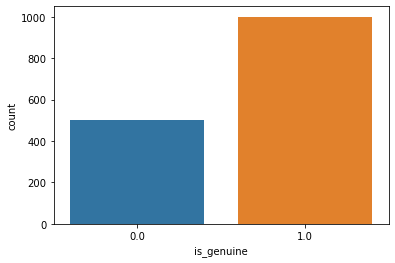

In [1446]:
sns.countplot(x = data['is_genuine'])
plt.show()

On voit que les classes sont relativement équilibrées, ainsi on ne risque pas de biais lors de l'entraînement des algorithmes.

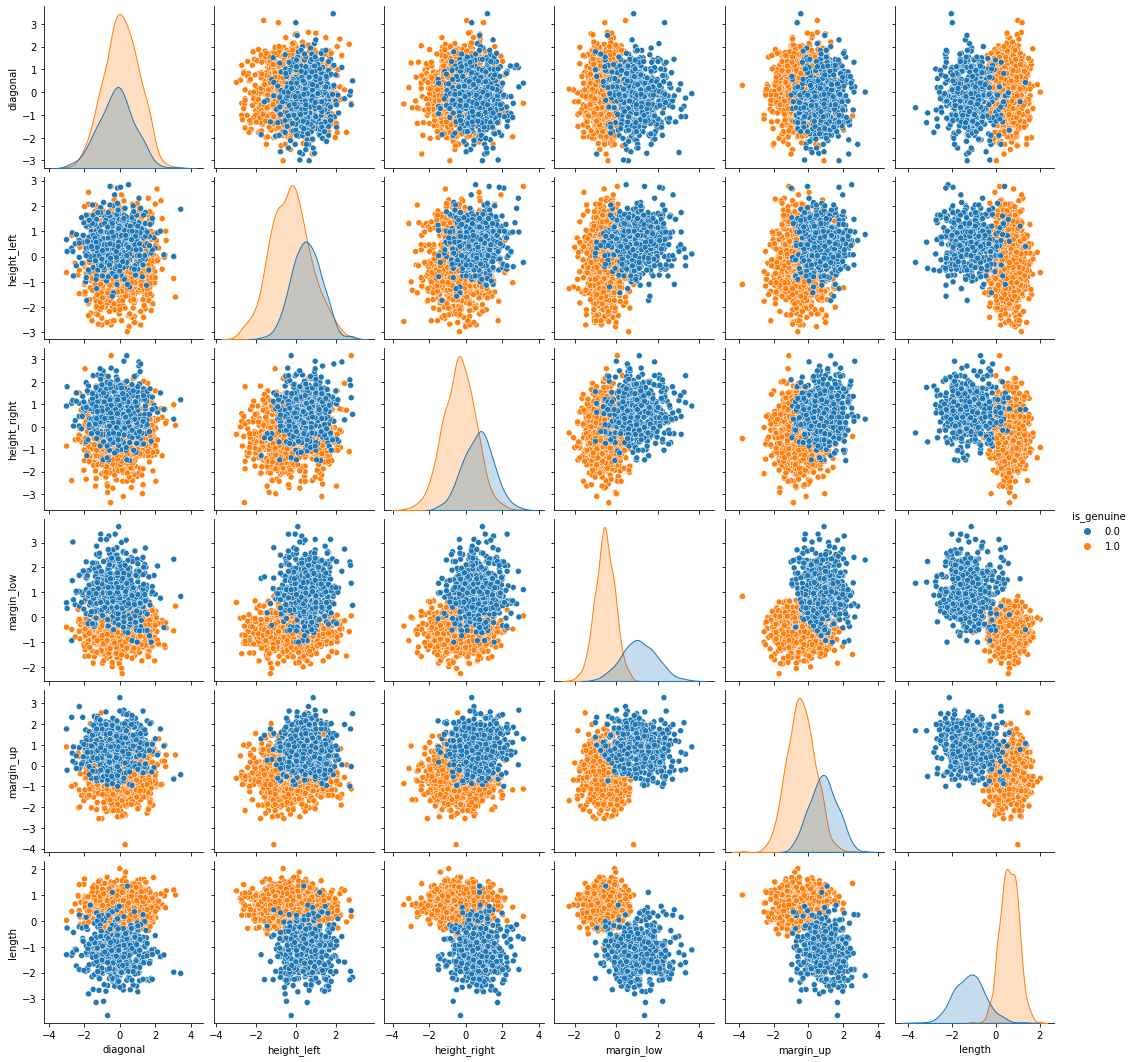

In [1447]:
sns.pairplot(data, hue = 'is_genuine')
plt.show()

Ce que l'on remarque ici, c'est que certaines variables permettent bien de distinguer les deux catégories de billets, et notamment la margin_low et la longueur.

### Première méthode de prédiction : Régression Logistique

On commence par essayer un algorithme de régression logistique sur nos données normalisées.

In [1448]:
X = data[feature_cols]
y = data['is_genuine']

De la même façon que pour la régression linéaire, on sépare le dataset en données d'entraînement et de test.

In [1449]:
X_train, X_test, y_train, y_pred = train_test_split(X, y)

In [1450]:
import statsmodels.api as sm
log_reg = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.042561
         Iterations 11


In [1451]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1125
Model:                          Logit   Df Residuals:                     1119
Method:                           MLE   Df Model:                            5
Date:                Wed, 27 Jul 2022   Pseudo R-squ.:                  0.9336
Time:                        19:46:27   Log-Likelihood:                -47.881
converged:                       True   LL-Null:                       -721.50
Covariance Type:            nonrobust   LLR p-value:                3.739e-289
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
diagonal        -0.0434      0.273     -0.159      0.874      -0.579       0.492
height_left     -0.4937      0.295     -1.672      0.094      -1.072       0.085
height_right    -0.6399      0.303     -2.11

La colonne P>|z| indique la significativité des variables dans la distinction des billets. Ici, les variables dont la valeur est supérieure à 5% sont la diagonale et la height_right (conformément aux observations faites sur le pairplot). Ainsi, pour optimiser notre modèle, on va supprimer ces colonnes, qui sont les moins significatives :

In [1452]:
logreg = LogisticRegression()
logreg.fit(X_train.drop(columns = {'diagonal', 'height_right'}), y_train)

LogisticRegression()

In [1453]:
print("Justesse du modèle sur les données d'entraînement : ", 
      round(100*logreg.score(X_train.drop(columns = {'diagonal', 'height_right'}), y_train),1), "%")

Justesse du modèle sur les données d'entraînement :  99.1 %


On voit que le modèle représente très bien les données d'entraînement.

In [1454]:
y_pred = logreg.predict(X_test.drop(columns = {'diagonal', 'height_right'}))
y_test = data_scaled.loc[X_test.index, 'is_genuine'].values

Pour évaluer la qualité du modèle, on commence par calculer le score de justesse de la prédiction :

In [1455]:
print("Score de justesse des prédictions : ", 
      round(100*logreg.score(X_test.drop(columns = {'diagonal', 'height_right'}), y_test),1), "%")

Score de justesse des prédictions :  99.5 %


On obtient un score de 99%, ce qui montre que les prédictions sont très justes.

On peut également regarder la matrice de confusion :

In [1456]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[115   2]
 [  0 258]]


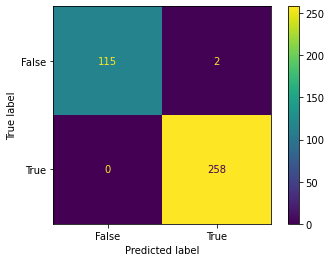

In [1457]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

La matrice de confusion est très satisfaisante. On a des ordres de grandeur pour les prédictions justes de 100 et pour les prédictions fausses de 1.

On vient compléter l'évaluation avec une courbe ROC, qui va caractériser la performance du modèle en comparant le taux de vrais positifs aux faux positifs. Plus la courbe se rapproche du coin supérieur gauche, plus le modèle est de qualité. Aussi, le score AUC complète la courbe en chiffrant l'aire sous la courbe. Plus ce score est proche de 1, plus le modèle est bon.

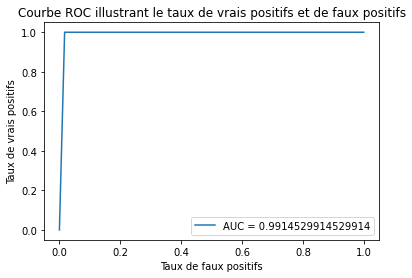

In [1458]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc_score = metrics.roc_auc_score(y_test, y_pred)

plt.plot(fpr, tpr, label="AUC = " + str(auc_score))
plt.legend()
plt.title("Courbe ROC illustrant le taux de vrais positifs et de faux positifs")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.show()

On a ici une courbe très écrasée sur le coin supérieur gauche, et un score AUC de 0.99, ce qui caractérise un modèle extrêmement juste pour les données traitées.

On termine en prédisant la nature des billets donnés :

In [1459]:
tmp = pd.DataFrame(scaler.transform(billets.drop(columns = {'id'})), columns = feature_cols) 
tmp['id'] = billets['id']
billets = tmp

X_pred = billets[feature_cols.drop(['diagonal', 'height_left'])]
y_pred = logreg.predict(X_pred).astype(bool)

billets['is_genuine_pred_logreg'] = y_pred
billets['is_genuine_proba'] = logreg.predict_proba(X_pred)[:,1]

billets[['id', 'is_genuine_pred_logreg', 'is_genuine_proba']]

,id,is_genuine_pred_logreg,is_genuine_proba
0,A_1,False,0.000628
1,A_2,False,0.000175
2,A_3,False,0.000537
3,A_4,True,0.987925
4,A_5,True,0.999721


Le modèle dit que les trois premiers billets sont faux, et les deux derniers sont vrais.

### Deuxième méthode de prédiction : k-means

On passe à la seconde méthode de prédiction : l'algorithme k-means. Ici, on sait qu'on cherche à distinguer 2 groupes, donc c'est ce qu'on indique en n_clusters.

In [1460]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(X_train, y_train)

KMeans(n_clusters=2)

In [1461]:
print("Score de Silhouette : ", round(metrics.silhouette_score(X_train, kmeans.labels_), 3))

Score de Silhouette :  0.345


Le score de Silhouette indique ici que les clusters sont modérément distincts.

In [1462]:
y_pred = kmeans.predict(X_test).astype(bool)

In [1463]:
y_test = data_scaled.loc[X_test.index, 'is_genuine'].values

Après entraînement du modèle de classification k-means, on regarde les indicateurs d'évaluation pour juger de sa qualité :

In [1464]:
acc_score = metrics.accuracy_score
print("Accuracy score : ", round(acc_score(y_test, y_pred)*100, 1), "%")

Accuracy score :  1.1 %


Le score de justesse ici est de 99%, ce qui est excellent.

In [1465]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[  1 116]
 [255   3]]


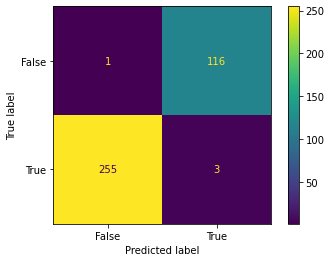

In [1466]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

Ici aussi, la matrice de confusion montre un excellent résultat.

On complète l'évaluation avec une courbe ROC et un score AUC :

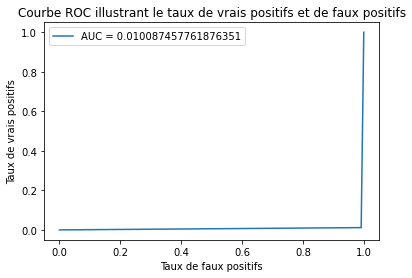

In [1467]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc_score = metrics.roc_auc_score(y_test, y_pred)

plt.plot(fpr, tpr, label="AUC = " + str(auc_score))
plt.legend()
plt.title("Courbe ROC illustrant le taux de vrais positifs et de faux positifs")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.show()

Comme on pouvait s'y attendre, la courbe est également très écrasée dans le coin supérieur gauche avec un score AUC de 0.99, ce qui prouve que le modèle est très juste sur ce jeu de données.

On termine en prédisant la nature des billets :

In [1468]:
X_pred = billets_scaled[feature_cols]
y_pred = kmeans.predict(X_pred).astype(bool)

billets_scaled['is_genuine_pred_km'] = y_pred
billets_scaled[['id', 'is_genuine_pred_logreg', 'is_genuine_pred_km']]

,id,is_genuine_pred_logreg,is_genuine_pred_km
0,A_1,False,True
1,A_2,False,True
2,A_3,False,True
3,A_4,True,False
4,A_5,True,False


Ici aussi, le modèle par classification rejoint le modèle par régression en étiquetant les 3 premiers billets comme faux et les 2 derniers comme authentiques.

### Choix du modèle et test sur un nouveau fichier

Ici, les deux algorithmes ont d'excellents résultats, mais le choix final se portera sur la régression logistique. En effet, l'algorithme de k-means est un algorithme de classification, et même s'il distingue les bons groupes, il peut les confondre et inverser les labels. Or ici on veut pouvoir compter sur un modèle plus fiable, c'est pourquoi on retient la régression, qu'on a en plus optimisé.

On réalise une fonction qui fait appel à l'algorithme de régression logistique préalablement entraîné pour : 

- importer un fichier de billets

- préparer les données du fichier à l'application de l'algorithme

- prédire et afficher les résultats

In [1469]:
# Définition d'une fonction utilisant l'algorithme entraîné

def nature_des_billets(file, logreg = logreg, scaler = scaler) :
    
    # import du fichier
        
    test = pd.read_csv("../Downloads/" + str(file) + ".csv")
    
    # normalisation des données
    
    feature_cols = test.columns.drop('id')
    
    test_scaled = pd.DataFrame(scaler.transform(test.drop(columns = {'id'})), columns = feature_cols)    

    # ré-application de la colonne id

    test_scaled['id'] = test['id']
    
    # récupération des dimensions des billets à tester puis prédiction de leur nature

    X_pred = test_scaled[feature_cols].drop(columns = {'diagonal', 'height_right'})
    y_pred = logreg.predict(X_pred).astype(bool)

    test_scaled['is_genuine_pred'] = y_pred
    test_scaled['is_genuine_proba'] = logreg.predict_proba(X_pred)[:,1]
    
    # remplacement des colonnes normalisées par les dimensions originelles
    
    test_scaled[feature_cols] = test[feature_cols]

    
    # affichage des résultats

    return test_scaled


In [1470]:
nature_des_billets('billets_production')

,diagonal,height_left,height_right,margin_low,margin_up,length,id,is_genuine_pred,is_genuine_proba
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False,0.000358
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False,0.000192
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False,0.000376
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True,0.984865
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True,0.999752
